Karolis Vėgėla, 2016061, Classes ['Bottle', 'Car', 'Dog'] Image Segmentation

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
images_directory = '/content/drive/MyDrive/GMM/IMAGES'
masks_directory = '/content/drive/MyDrive/GMM/MASKS'

In [4]:
batch_size = 15
target_size = (256, 256)

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

image_generator = image_datagen.flow_from_directory(
    images_directory,
    target_size=target_size,
    class_mode=None,
    batch_size=batch_size,
    seed=123
)

mask_generator = mask_datagen.flow_from_directory(
    masks_directory,
    target_size=target_size,
    color_mode='grayscale',
    class_mode=None,
    batch_size=batch_size,
    seed=123
)

def categorical_mask_generator(mask_generator):
    for batch in mask_generator:
        yield tf.squeeze(tf.one_hot(tf.cast(batch * 255, tf.uint8), 3), axis=-2)

categorical_mask_generator = categorical_mask_generator(mask_generator)

train_generator = zip(image_generator, categorical_mask_generator)
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([batch_size] + list(target_size) + [3], [batch_size] + list(target_size) + [3])
)
train_ds = train_ds.cache('/content/drive/MyDrive/CACHE')
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

Found 2700 images belonging to 3 classes.
Found 2700 images belonging to 3 classes.


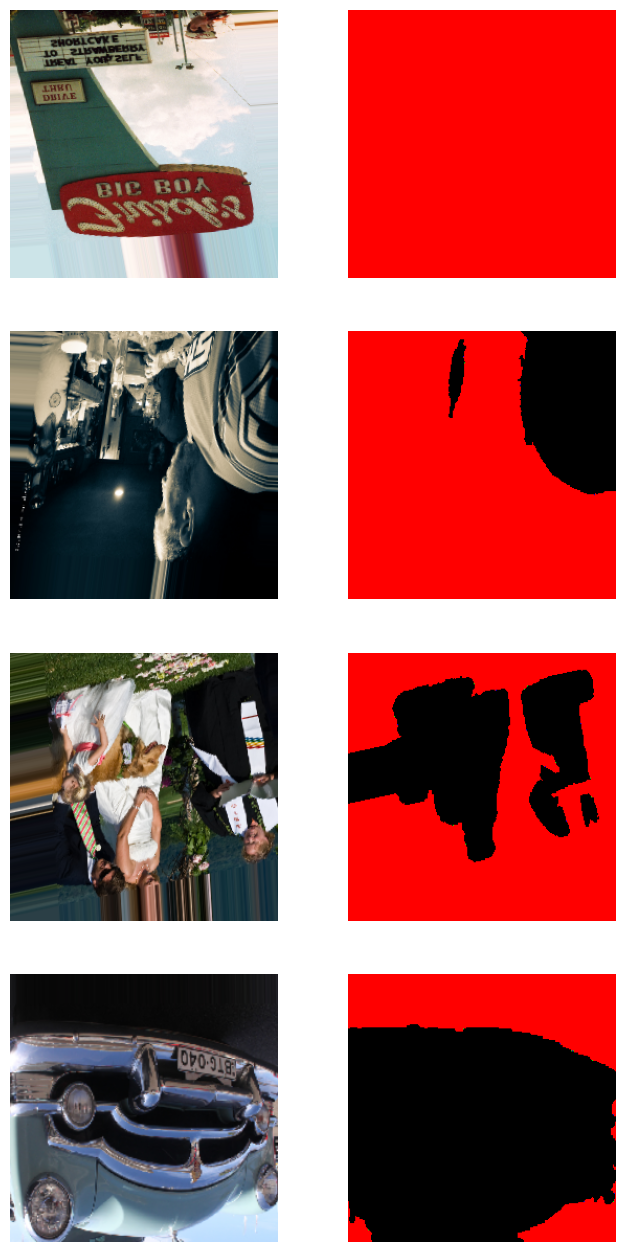

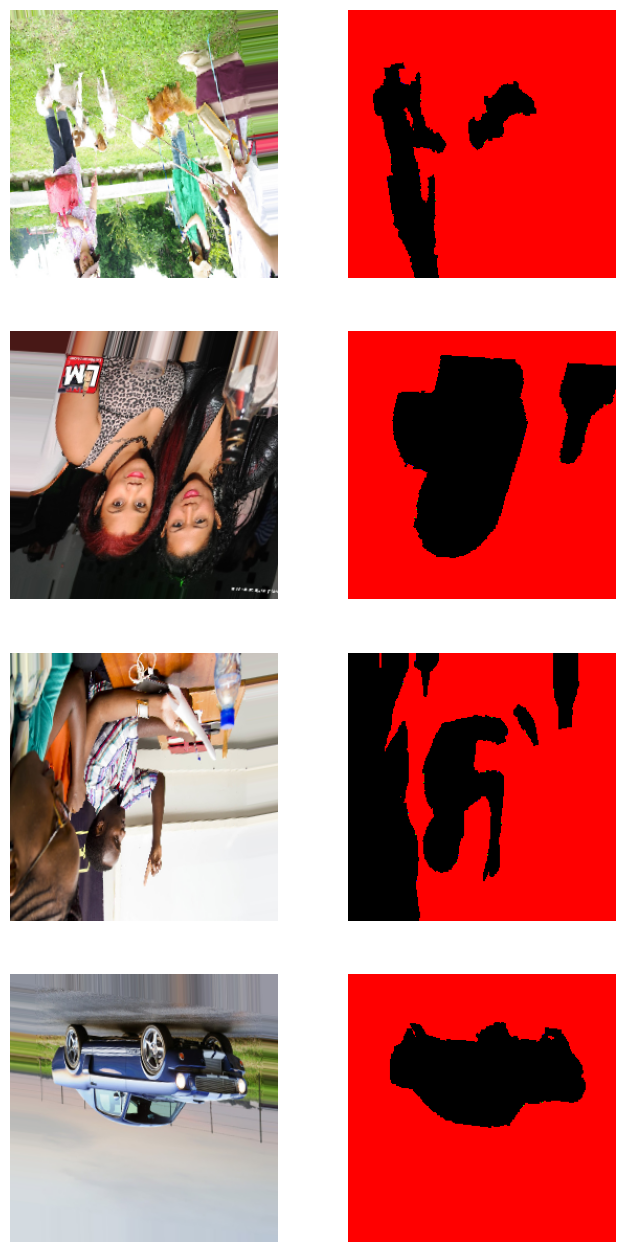

In [ ]:
for images, masks in train_ds.take(2):
    fig, ax = plt.subplots(4, 2, figsize=(8, 16))
    for i in range(4):
        # Plot the image
        ax[i, 0].imshow(images[i])
        ax[i, 0].axis('off')
        # Plot the mask
        ax[i, 1].imshow(tf.squeeze(masks[i]))
        ax[i, 1].axis('off')
    plt.show()

In [5]:
def double_conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_model():
    inputs = tf.keras.layers.Input(shape=(256,256,3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
    model = tf.keras.Model(inputs, outputs)

    return model

In [6]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss="categorical_crossentropy",
                   metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
history = model.fit(train_ds, steps_per_epoch=180, epochs=6, verbose=1)

Epoch 1/6
180/180 [==============================] - 1812s 10s/step - loss: 0.8067 - categorical_accuracy: 0.5263
Epoch 2/6
180/180 [==============================] - 204s 1s/step - loss: 0.6518 - categorical_accuracy: 0.7323
Epoch 3/6
180/180 [==============================] - 207s 1s/step - loss: 0.5608 - categorical_accuracy: 0.8059
Epoch 4/6
180/180 [==============================] - 208s 1s/step - loss: 0.4823 - categorical_accuracy: 0.8869
Epoch 5/6
180/180 [==============================] - 207s 1s/step - loss: 0.4196 - categorical_accuracy: 0.9424
Epoch 6/6
180/180 [==============================] - 206s 1s/step - loss: 0.3681 - categorical_accuracy: 0.9643


In [ ]:
model.save('/content/drive/MyDrive/SEGMETAVIMO_MODELIS')

In [7]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/SEGMETAVIMO_MODELIS')

In [8]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/mano nuotraukos/',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

predictions = loaded_model.predict(test_generator, steps=len(test_generator))

Found 5 images belonging to 3 classes.
1/1 [==============================] - 3s 3s/step


In [9]:
predicted_masks = np.argmax(predictions, axis=-1)

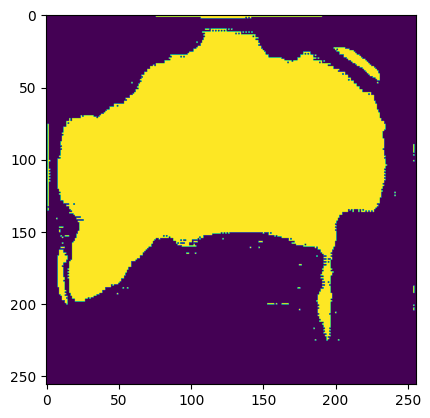

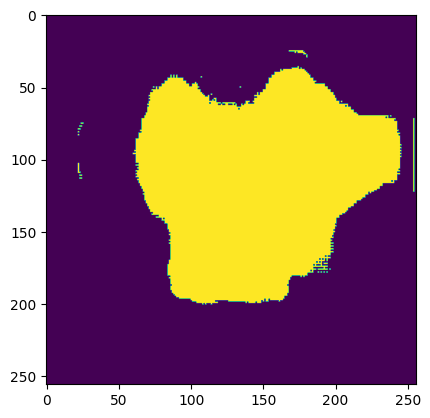

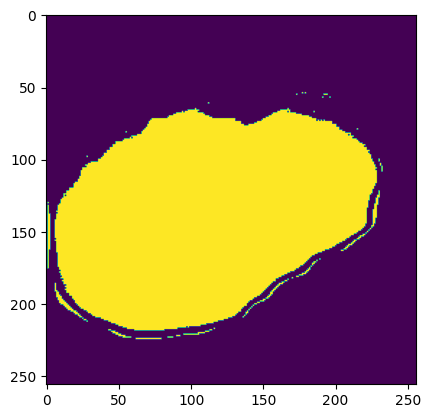

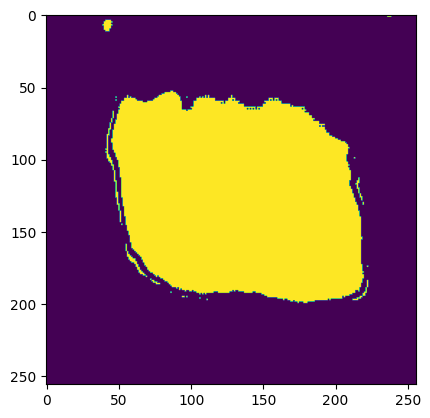

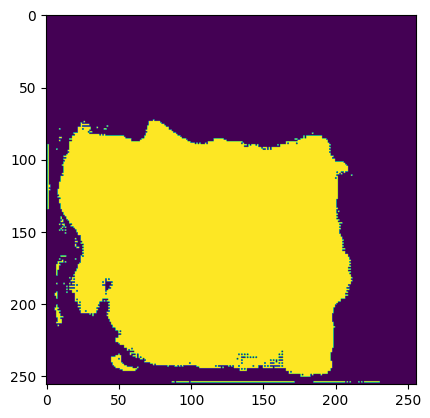

In [10]:
for i in range(len(predictions)):
  plt.imshow(predicted_masks[i])
  plt.show()

In [20]:
# STATISTICS CALCULATION
def data_loader_train(folder_dir):
    ds_images = []
    files = os.listdir(folder_dir)
    files.sort()
    for images in files:
        image = cv.imread(folder_dir + '/' + images, 1)
        image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
        image = cv.resize(image, (256, 256))
        image = Image.fromarray(image)
        image = np.array(image)
        ds_images.append(image)
    return ds_images

def data_loader_masks(folder_dir):
    ds_images = []
    files = os.listdir(folder_dir)
    files.sort()
    for images in files:
        image = cv.imread(folder_dir + '/' + images, 1)
        image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
        image = cv.resize(image, (256, 256))
        image = Image.fromarray(image)
        image = np.array(image)
        ds_images.append(image)
    return ds_images

In [21]:
root_dir = '/content/drive/MyDrive/GMM/test/'
ds_test_images = data_loader_train(root_dir + 'IMAGES/bottle/') + data_loader_train(root_dir + 'IMAGES/car/') + data_loader_train(root_dir + 'IMAGES/dog/')
ds_test_masks = data_loader_masks(root_dir + 'MASKS/bottle/') + data_loader_masks(root_dir + 'MASKS/car/') + data_loader_masks(root_dir + 'MASKS/dog/')

In [22]:
ds_test_images = np.array(ds_test_images)
ds_test_masks = np.array(ds_test_masks)

In [51]:
# Load the test dataset
test_datagen_normalus = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator_normalus = test_datagen_normalus.flow_from_directory(
    '/content/drive/MyDrive/GMM/test/IMAGES',
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False 
)

Found 300 images belonging to 3 classes.


In [64]:
last_predictions = loaded_model.predict(test_generator_normalus)

20/20 [==============================] - 6s 286ms/step


In [68]:
pred_masks = np.argmax(last_predictions, axis=-1)

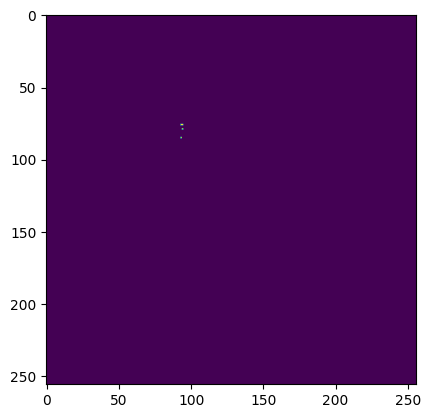

In [113]:
plt.imshow(pred_masks[150])

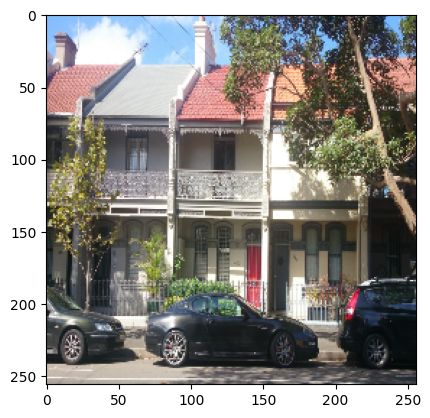

In [114]:
plt.imshow(ds_test_images[150])

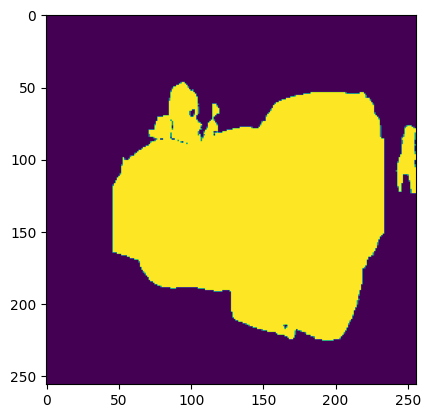

In [112]:
plt.imshow(ds_test_masks[186])

In [77]:
from sklearn.metrics import confusion_matrix, f1_score

predicted_masks = np.argmax(last_predictions, axis=-1)

In [79]:
conf_mat = confusion_matrix(ds_test_masks.flatten(), predicted_masks.flatten())

In [81]:
dice = 2 * conf_mat[1,1] / (2 * conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0])
micro_f1 = f1_score(ds_test_masks.flatten(), predicted_masks.flatten(), average='micro')
macro_f1 = f1_score(ds_test_masks.flatten(), predicted_masks.flatten(), average='macro')

In [85]:
print(f'Dice: {dice}; Micro_F1: {micro_f1}; Macro_F1: {macro_f1}')

Dice: 0.0; Micro_F1: 0.592828877766927; Macro_F1: 0.0032028240381991495
